In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
pd.options.display.max_columns = 100
%matplotlib inline

In [2]:
data = pd.read_csv('input/train.csv')

In [3]:
data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


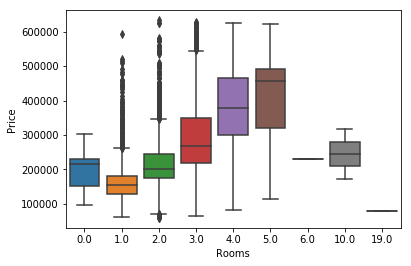

In [4]:
sns.boxplot(data['Rooms'], data['Price']);

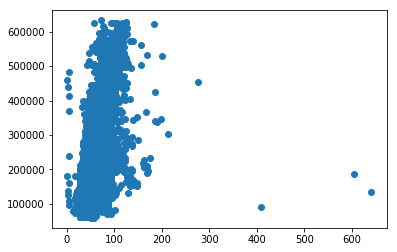

In [5]:
plt.scatter(data['Square'], data['Price']);

In [6]:
# Функция возвращает медиану площати для каждого типа квартир
def get_rooms_median(df):
    dfr = df.loc[df['Rooms'].between(1,5), ['Rooms','Square']].groupby('Rooms', as_index=False)['Square'] \
        .median().rename(columns={'Square':'Square_median'})
    return dfr

In [7]:
# Функция подбирает наиболее подходящую величину комнат на основе медианы площати для каждого типа квартир
def fill_rooms(df, dfrm):
    dfr = pd.merge(df.loc[~df['Rooms'].between(1,6), ['Id', 'Square']].assign(tmp=1),
                dfrm.assign(tmp=1),
                on='tmp').drop('tmp',axis=1)
    dfr.loc[:, 'sq_diff'] = (dfr['Square'] - dfr['Square_median']).abs()
    dfr = dfr.assign(rn=dfr.groupby('Id')['sq_diff'].rank(method='first', ascending=True)).query('rn==1')
    
    df.loc[df['Id'].isin(dfr['Id']) ,['Rooms']] = df['Id'].map(dfr.set_index('Id')['Rooms'])

    return df

In [8]:
# Функция исправляет поле Square в случае если LifeSquare существенно превышает Square
def fill_square(df):
    df.loc[(df['Square'] / df['LifeSquare'] < 0.2) & (df['Square'] < 10), 'Square'] = df['LifeSquare']
    return df

In [9]:
# Функция заполняет и исправляет LifeSquare
def fill_lifesquare(df, dfm):
    # Набор данных, на основе которых будем вычислять средние значения LifeSquare
    df1 = dfm.loc[~dfm['LifeSquare'].isnull() & ~(dfm['LifeSquare'] / dfm['Square'] < 0.2) & ~(dfm['LifeSquare'] / dfm['Square'] > 1.5), 
                     ['Rooms', 'DistrictId', 'Social_1', 'Social_2', 'Square', 'LifeSquare']]
    df1.loc[:, 'SquareD'] = (df1['Square'] // 10).astype(int)
    
    # Набор данных, которому будут присваиваться средние значения LifeSquare
    df2 = df.loc[df['LifeSquare'].isnull() | (df['LifeSquare'] / df['Square'] < 0.2) | (df['LifeSquare'] / df['Square'] > 1.5), 
                     ['Id', 'Rooms', 'DistrictId', 'Social_1', 'Social_2', 'Square', 'LifeSquare']]
    df2.loc[:, 'SquareD'] = (df2['Square'] // 10).astype(int) 
    df2.loc[:, 'LifeSquare'] = np.NaN
    
    # Средние значения присваиваются в цикле с увеличением степени группировки для групп значений, которые не удалось подобрать
    gr_fields = ['Rooms', 'SquareD', 'DistrictId', 'Social_1', 'Social_2']
    for i in range(len(gr_fields)):
        dft = df1.groupby(gr_fields, as_index=False)['LifeSquare'].median().rename(columns={'LifeSquare':'LifeSquare_mean'})    
        df2 = pd.merge(df2, dft, on=gr_fields, how='left')
        df2.loc[df2['LifeSquare'].isnull(),'LifeSquare'] = df2['LifeSquare_mean']
        df2 = df2.drop('LifeSquare_mean',axis=1)
        gr_fields.pop()
        
    df.loc[df['Id'].isin(df2['Id']) ,['LifeSquare']] = df['Id'].map(df2.set_index('Id')['LifeSquare'])
    return df

In [10]:
def transform_cat_features(df):
    df = pd.get_dummies(df)
    return df

In [11]:
def fill_helthcare(df):
    df['Healthcare_1'] = df['Healthcare_1'].fillna(0).astype(int)
    return df

In [12]:
def prepare_data(df, train_df):
    df = fill_rooms(df, get_rooms_median(train_df))
    df = fill_square(df)
    df = fill_lifesquare(df, train_df)
    df = transform_cat_features(df)
    df = fill_helthcare(df)
    return df

### Разбиение исходного набора данных на train и valid

In [13]:
train, valid = train_test_split(data, test_size=0.3, random_state=542)

### Подготовка train

In [14]:
 train = prepare_data(train, train)

In [15]:
train.shape

(7000, 23)

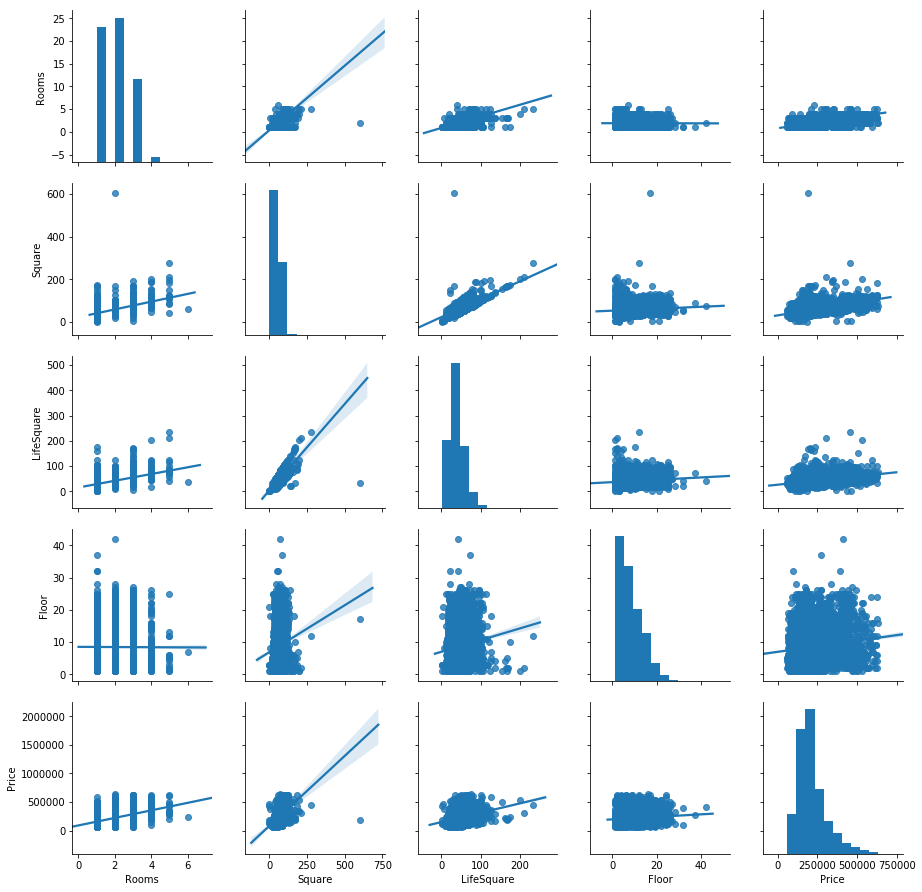

In [16]:
sns.pairplot(train.loc[:, ['Rooms', 'Square', 'LifeSquare', 'Floor', 'Price']], kind='reg');

### Подготовка valid

In [17]:
valid = prepare_data(valid, train)

In [18]:
valid.shape

(3000, 23)

### Создание модели

In [19]:
from sklearn.ensemble import RandomForestRegressor as RF

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 7648 to 5751
Data columns (total 23 columns):
Id               7000 non-null int64
DistrictId       7000 non-null int64
Rooms            7000 non-null float64
Square           7000 non-null float64
LifeSquare       7000 non-null float64
KitchenSquare    7000 non-null float64
Floor            7000 non-null int64
HouseFloor       7000 non-null float64
HouseYear        7000 non-null int64
Ecology_1        7000 non-null float64
Social_1         7000 non-null int64
Social_2         7000 non-null int64
Social_3         7000 non-null int64
Healthcare_1     7000 non-null int32
Helthcare_2      7000 non-null int64
Shops_1          7000 non-null int64
Price            7000 non-null float64
Ecology_2_A      7000 non-null uint8
Ecology_2_B      7000 non-null uint8
Ecology_3_A      7000 non-null uint8
Ecology_3_B      7000 non-null uint8
Shops_2_A        7000 non-null uint8
Shops_2_B        7000 non-null uint8
dtypes: float64(7), int32

In [21]:
model = RF(n_estimators=1000, max_depth=16, max_features=6, n_jobs=-1, random_state=542)

In [22]:
fts = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2',
       'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1',
       'Ecology_2_A', 'Ecology_3_A', 'Shops_2_A']

In [23]:
model.fit(train.loc[:, fts], train['Price'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=16,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=-1, oob_score=False, random_state=542,
           verbose=0, warm_start=False)

In [24]:
pred_train = model.predict(train.loc[:, fts])

In [25]:
pred_valid = model.predict(valid.loc[:, fts])

In [26]:
from sklearn.metrics import r2_score as r2

In [27]:
r2(train['Price'], pred_train)

0.9466799007813967

In [28]:
r2(valid['Price'], pred_valid)

0.7503428913025381

### Формирование файла для теста

In [29]:
test_data = pd.read_csv('input/test.csv')

In [30]:
test_data = prepare_data(test_data, train)

In [31]:
test_data['Price'] = model.predict(test_data.loc[:, fts])

In [32]:
test_data.loc[:, ['Id', 'Price']].to_csv('DZverkov_predictions.csv', index=False)